In [1]:
import pandas as pd

df = pd.read_csv('nyc_taxi_trip_duration.csv')
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id1080784,2,2016-02-29 16:40:21,2016-02-29 16:47:01,1,-73.953918,40.778873,-73.963875,40.771164,N,400
1,id0889885,1,2016-03-11 23:35:37,2016-03-11 23:53:57,2,-73.988312,40.731743,-73.994751,40.694931,N,1100
2,id0857912,2,2016-02-21 17:59:33,2016-02-21 18:26:48,2,-73.997314,40.721458,-73.948029,40.774918,N,1635
3,id3744273,2,2016-01-05 09:44:31,2016-01-05 10:03:32,6,-73.961670,40.759720,-73.956779,40.780628,N,1141
4,id0232939,1,2016-02-17 06:42:23,2016-02-17 06:56:31,1,-74.017120,40.708469,-73.988182,40.740631,N,848


In [2]:
import datetime as dt


def convert_to_datetime(date):
    return dt.datetime.strptime(date, '%Y-%m-%d %H:%M:%S')

In [3]:
df['date'] = df.apply(lambda row: convert_to_datetime(row['pickup_datetime']), axis=1)

In [24]:
start_time = df['date'].min()
df['hour'] = df.apply(lambda row: (row['date'] - start_time).total_seconds() // 3600, axis=1)

In [27]:
len(df['hour'].unique())

4357

In [34]:
trips_dur = df.groupby(['hour']).agg({'trip_duration': 'mean'}).reset_index()

In [35]:
trips_dur

,hour,trip_duration
0,0.0,1123.191489
1,1.0,1154.472603
2,2.0,827.404348
3,3.0,1187.324786
4,4.0,849.271605
...,...,...
4352,4363.0,847.882353
4353,4364.0,1254.826667
4354,4365.0,836.429134
4355,4366.0,1266.547325


In [120]:
from sklearn.ensemble import IsolationForest

anomaly_inputs = ['trip_duration']

model = IsolationForest(contamination=0.01, n_estimators=1000, max_samples=100)
model.fit(trips_dur[anomaly_inputs])


IsolationForest(contamination=0.01, max_samples=100, n_estimators=1000)

In [121]:
trips_dur['anomaly'] = model.predict(trips_dur[anomaly_inputs])

In [122]:
# months = ]
df['month'] = df.apply(lambda r: r['date'].strftime('%b %Y'), axis=1)

In [123]:
df['month'].unique()
months = df.groupby(['month']).agg({'hour': 'max'}).reset_index()

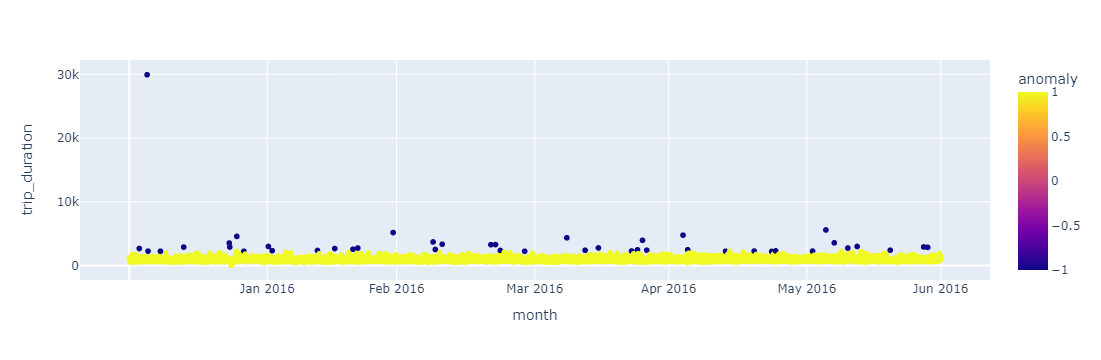

In [124]:
import plotly.express as px
fig = px.scatter(trips_dur, x='hour', y='trip_duration', color='anomaly', labels=['Mar 2016', 'Feb 2016'])
fig.update_layout(
    xaxis=dict(
        tickmode = 'array',
        tickvals = months['hour'],
        ticktext = months['month'],
        title='month'
    )
)
fig.show()

In [125]:
df[df['hour'].isin(trips_dur[trips_dur['anomaly'] == -1]['hour'])].shape

(3035, 14)

In [95]:
trips_amount = df.groupby(['hour']).agg({'trip_duration': 'count'}).reset_index()
trips_amount

,hour,trip_duration
0,0.0,282
1,1.0,292
2,2.0,230
3,3.0,234
4,4.0,162
...,...,...
4352,4363.0,255
4353,4364.0,225
4354,4365.0,254
4355,4366.0,243


In [126]:
anomaly_inputs = ['trip_duration']

model = IsolationForest(contamination=0.01, n_estimators=1000, max_samples=100)
model.fit(trips_amount[anomaly_inputs])

IsolationForest(contamination=0.01, max_samples=100, n_estimators=1000)

In [127]:
trips_amount['anomaly'] = model.predict(trips_amount[anomaly_inputs])

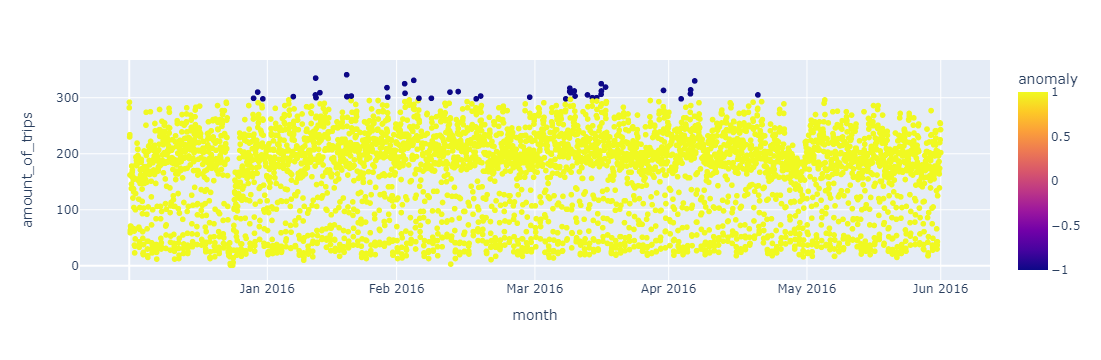

In [128]:
fig = px.scatter(trips_amount, x='hour', y='trip_duration', color='anomaly', labels=['Mar 2016', 'Feb 2016'])
fig.update_layout(
    xaxis=dict(
        tickmode = 'array',
        tickvals = months['hour'],
        ticktext = months['month'],
        title='month'
    ),
    yaxis_title='amount_of_trips'
)
fig.show()

In [129]:
df[df['hour'].isin(trips_amount[trips_amount['anomaly'] == -1]['hour'])].shape

(13294, 14)

In [130]:
from math import cos, radians


def distance(longitude1, latitude1, longitude2, latitude2):
  degree_kilometres = 111.2
  latitude_dif = degree_kilometres * abs(latitude2 - latitude1)
  longitude_dif = abs(longitude1 - longitude2)
  AD = degree_kilometres * cos(radians(latitude1)) * longitude_dif
  BC = degree_kilometres * cos(radians(latitude2)) * longitude_dif
  temp = (AD - BC) / 2
  H = (latitude_dif ** 2 - temp ** 2) ** 0.5
  return ((max(AD, BC) - temp) ** 2 + H ** 2) ** 0.5 * 1000

In [134]:
df['distance'] = df.apply(lambda row: distance(
    row['pickup_longitude'],
    row['pickup_latitude'],
    row['dropoff_longitude'],
    row['dropoff_latitude'],
), axis=1)

dist = df.groupby(['hour']).agg(distance=('distance', 'mean')).reset_index()
dist

,hour,distance
0,0.0,3616.591292
1,1.0,3851.591488
2,2.0,4128.295098
3,3.0,4071.823098
4,4.0,4568.659245
...,...,...
4352,4363.0,2988.026443
4353,4364.0,4023.578478
4354,4365.0,3584.864207
4355,4366.0,3663.653097


In [144]:
anomaly_inputs = ['distance']

model = IsolationForest(contamination=0.01, n_estimators=1000, max_samples=1000)
model.fit(dist[anomaly_inputs])

IsolationForest(contamination=0.01, max_samples=1000, n_estimators=1000)

In [145]:
dist['anomaly'] = model.predict(dist[anomaly_inputs])

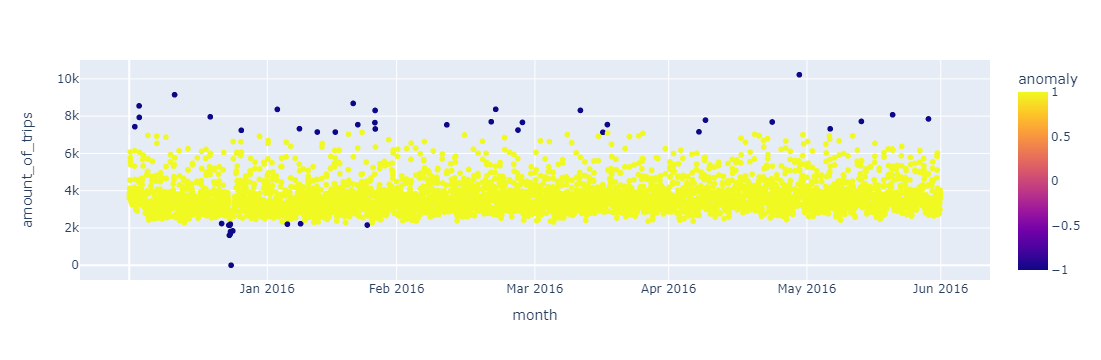

In [146]:
fig = px.scatter(dist, x='hour', y='distance', color='anomaly', labels=['Mar 2016', 'Feb 2016'])
fig.update_layout(
    xaxis=dict(
        tickmode = 'array',
        tickvals = months['hour'],
        ticktext = months['month'],
        title='month'
    ),
    yaxis_title='amount_of_trips'
)
fig.show()

In [147]:
df[df['hour'].isin(dist[dist['anomaly'] == -1]['hour'])].shape

(2121, 15)